# Ada boost classifier

## Step 1 : Include all required libraries.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

## Step 2 : Defining the Adaboost class. And algorithm as:
    input:
      training set S = (x1, y1), . . . ,(xm, ym)
      weak learner WL
      number of rounds T
    initialize D(1) = ( 1/m , . . . ,1/m ).
    for t = 1, . . . , T:
      invoke weak learner ht = WL(D(t), S)
      compute et=sum_i_m(Di(t)*1[yi!=ht(xi)])
      let wt =1/2*log(1-et/et)
      update D(t+1)i = D(t)i*exp(−wt*yi*ht(xi))/sum j=1 to m  D(t)j*exp(−wt*yj*ht(xj ))for all i = 1, . . . , m
    output the hypothesis hs(x) = sign(sum t=1 to T wt*ht(x)).

In [74]:
class AdaBoost_classifier:
    # Defining the initial values of the variables
    def __init__(self):
        self.decision_stumps = None
        self.decision_stump_weights = None
        self.classifier_errors = None
        self.classifier_sample_weights = None

    # checking the values of y label as +1 and -1 
    def check_X_y(self, X, y):
        if set(y) == {-1, 1} : 
          return X, y
        else :
          return False

    # Fitting the model using decision stumps.
    def fit_model(self, X , y , iterations , iteration_information):
        X, y = self.check_X_y(X, y)
        n = X.shape[0]

        # initialise numpy arrays
        self.classifier_sample_weights = np.zeros(shape=(iterations, n))
        self.decision_stumps = np.zeros(shape=iterations, dtype=object)
        self.decision_stump_weights = np.zeros(shape=iterations)
        self.classifier_errors = np.zeros(shape=iterations)

        # initialize weights uniformly as 1/n n= number of examples
        self.classifier_sample_weights[0] = np.ones(shape=n) / n

        for t in range(iterations):

            # fit  weak learner use decision tree classifier with depth 1 and leaves as 2 to create a decision stump
            curr_sample_weights = self.classifier_sample_weights[t]
            stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
            stump = stump.fit(X, y, sample_weight=curr_sample_weights)

            # calculate error and stump weight from weak learner prediction error = 1/2*log(1/e-1)
            stump_pred = stump.predict(X)
            err = curr_sample_weights[(stump_pred != y)].sum()
            stump_weight = np.log((1 - err) / err) / 2

            # update sample weights by usng the formula D*e(-W*y*h(x))
            new_sample_weights = (
                curr_sample_weights * np.exp(-stump_weight * y * stump_pred)
            )            
            new_sample_weights /= new_sample_weights.sum()

            if iteration_information == True:
              print("Error for iteration ",t," is ",err,'\n')
              print("Stump Weight for iteration ",t," is ",stump_weight,'\n')
              print("New Stump Weight for iteration ",t," is ",new_sample_weights,'\n')
            # If not final iteration, update sample weights for t+1
            if t+1 < iterations:
                self.classifier_sample_weights[t+1] = new_sample_weights

            # save results of iteration
            self.decision_stumps[t] = stump
            self.decision_stump_weights[t] = stump_weight
            self.classifier_errors[t] = err
        return self

    def predict(self, X):
        stump_preds = np.array([stump.predict(X) for stump in self.decision_stumps])
        return np.sign(np.dot(self.decision_stump_weights, stump_preds))

## Step 3 : Defining the functions used for visualizing the classifier.

In [75]:
# Defining the function to plot the decision boundary of adaboost classifier
def plot_adaboost_in2D(X,y,classifier=None,classifier_sample_weights=None):
    # checking for target to be 1 and -1 
    assert set(y) == {-1, 1}
    # Defining the figure size and the dpi
    figure, axes = plt.subplots(figsize=(7, 7), dpi=100)
    # background color set as white 
    figure.set_facecolor('white')
    # defining the boundary padding of the data points
    padding_for_boundary = 1
    x_min, x_max = X[:, 0].min() - padding_for_boundary, X[:, 0].max() + padding_for_boundary
    y_min, y_max = X[:, 1].min() - padding_for_boundary, X[:, 1].max() + padding_for_boundary
    
    # If sample weights are not given then assigning size using shape
    if classifier_sample_weights is not None:
        size = np.array(classifier_sample_weights) * X.shape[0] * 100
    else:
        size = np.ones(shape=X.shape[0]) * 100
    
    # Potting the positive that is 1 data points using scatter plot using color blue
    X_positive = X[y == 1]
    size_positive = size[y == 1]
    axes.scatter(*X_positive.T, s=size_positive, marker='+', color='blue')
    
    # Potting the negative that is -1 data points using scatter plot using color red
    X_negative = X[y == -1]
    size_negative = size[y == -1]
    axes.scatter(*X_negative.T, s=size_negative, marker='.', c='red')

    # if classifier is not provided then no decision boundary is drawn
    if classifier:
        plot_step = 0.01
        # using meshgrid to draw the decision boundary of adaboost classifier
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['b']
        else:
            fill_colors = ['r', 'b']
        axes.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)
    
    axes.set_xlim(x_min+0.5, x_max-0.5)
    axes.set_ylim(y_min+0.5, y_max-0.5)
    axes.set_xlabel('$x_1$')
    axes.set_ylabel('$x_2$')

## Step 4 : Defining the Function to create a random 2d dataset, and creating Training and test set. 

In [76]:
def make_2D_gaussian_dataset( n , random_seed):
    n_per_class = int(n/3)
    if random_seed:
        np.random.seed(random_seed)
    X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2)
    return X, y*2-1

## Step 5 : Creating the 2d Data set.

Total Data points : 150
Total Data points in traing set : 105
Total Data points in test set : 45


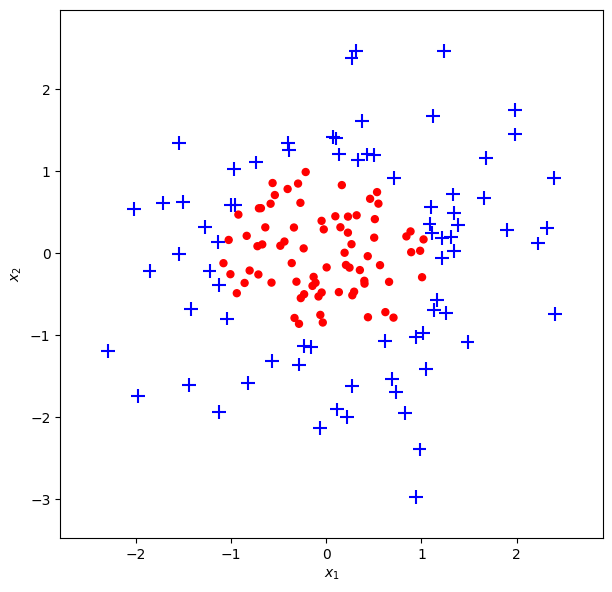

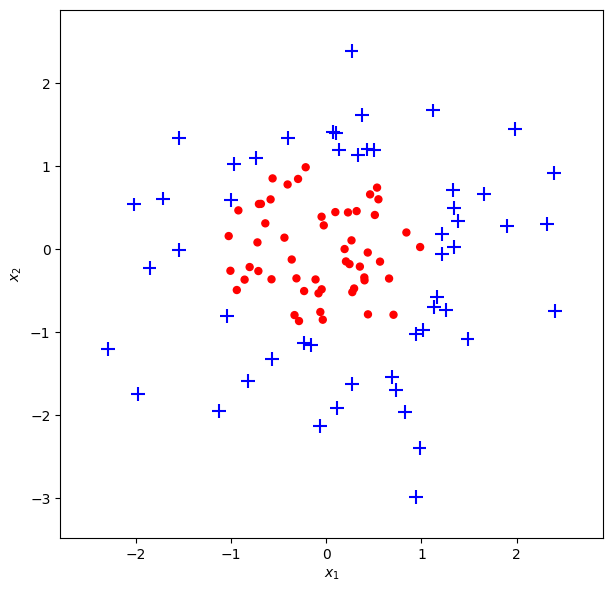

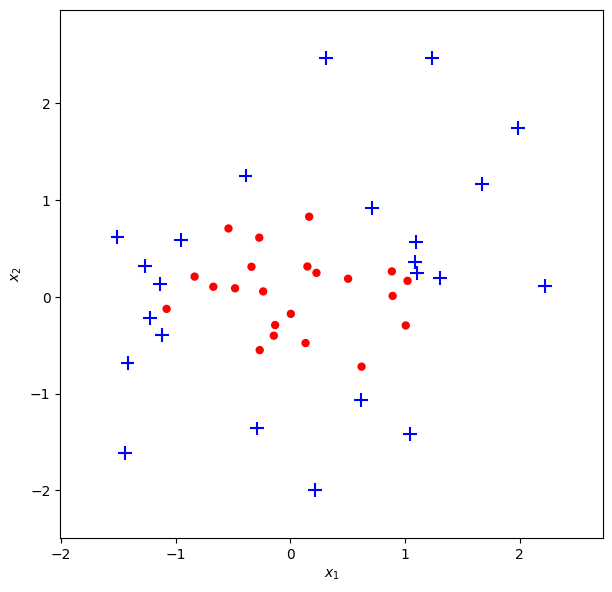

In [77]:
# defining n the number of total data points.
n = 150
X, y = make_2D_gaussian_dataset(n, random_seed=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print("Total Data points :",n)
plot_adaboost_in2D(X, y)
print("Total Data points in traing set :",X_train.shape[0])
plot_adaboost_in2D(X_train, y_train)
print("Total Data points in test set :",X_test.shape[0])
plot_adaboost_in2D(X_test, y_test)

## Step 6 : Creating classifier and fitting the classifier.  

In [78]:
# defining the number of iteations as i
i = 10
clf = AdaBoost_classifier().fit_model(X_train, y_train, iterations=i,iteration_information=True)
print("Final updated values of weights for ",i," Decision stumps are:")
print(clf.decision_stump_weights)

Error for iteration  0  is  0.29523809523809535 

Stump Weight for iteration  0  is  0.4350389443595115 

New Stump Weight for iteration  0  is  [0.01612903 0.00675676 0.00675676 0.00675676 0.00675676 0.01612903
 0.00675676 0.00675676 0.00675676 0.01612903 0.00675676 0.00675676
 0.00675676 0.00675676 0.00675676 0.00675676 0.00675676 0.01612903
 0.00675676 0.01612903 0.01612903 0.00675676 0.01612903 0.01612903
 0.00675676 0.01612903 0.01612903 0.00675676 0.00675676 0.00675676
 0.00675676 0.00675676 0.00675676 0.00675676 0.00675676 0.00675676
 0.00675676 0.00675676 0.00675676 0.00675676 0.01612903 0.00675676
 0.00675676 0.00675676 0.00675676 0.00675676 0.00675676 0.00675676
 0.01612903 0.01612903 0.01612903 0.00675676 0.00675676 0.01612903
 0.00675676 0.01612903 0.00675676 0.01612903 0.01612903 0.00675676
 0.01612903 0.01612903 0.01612903 0.01612903 0.00675676 0.00675676
 0.00675676 0.00675676 0.00675676 0.01612903 0.01612903 0.01612903
 0.01612903 0.00675676 0.00675676 0.01612903 0.0067

## Step 7 : plotting the classifier output and checking for error.

Train error: 2.857142857142857
Test error: 15.555555555555555


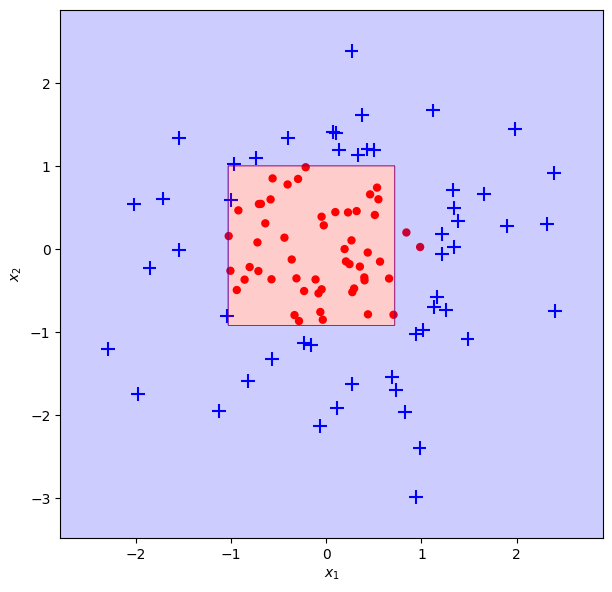

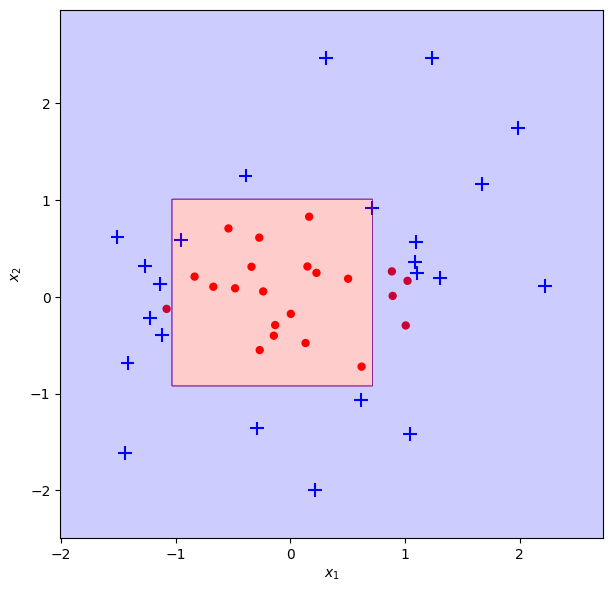

In [79]:
plot_adaboost_in2D(X_train, y_train, clf)
train_err = (clf.predict(X_train) != y_train).mean() * 100
print('Train error:',train_err)
plot_adaboost_in2D(X_test, y_test, clf)
test_err = (clf.predict(X_test) != y_test).mean() * 100
print('Test error:',test_err)

# Step 8 : Using the Adaboost provided in sklearn to check for accuracy of defined model.

Train error: 2.857142857142857
Test error: 15.555555555555555


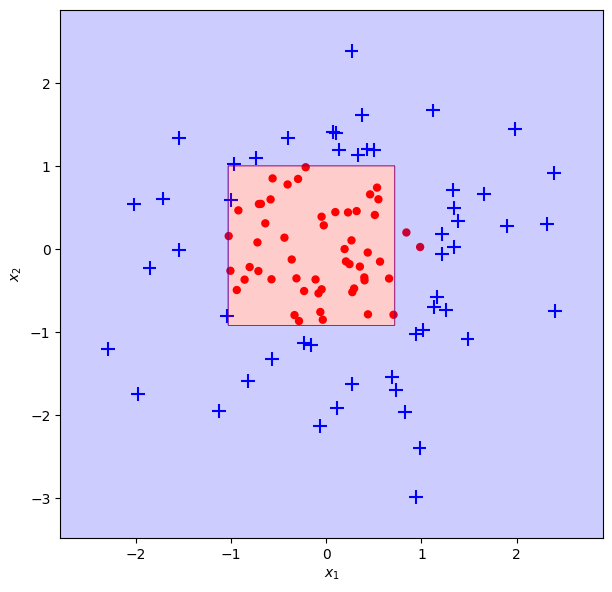

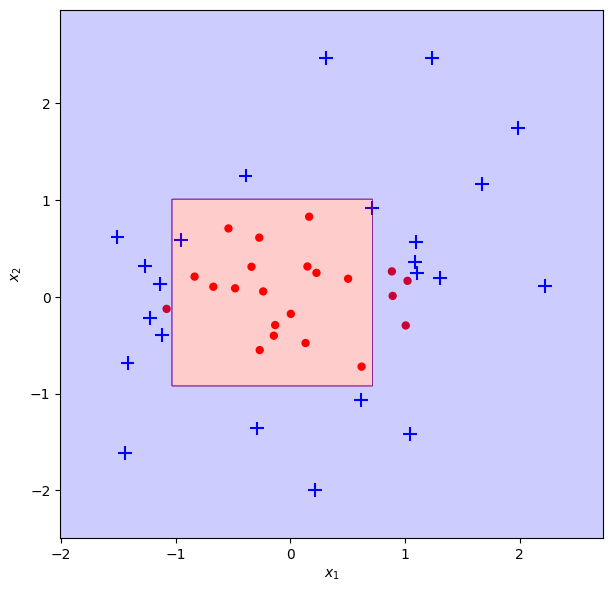

In [80]:
from sklearn.ensemble import AdaBoostClassifier
benchmark = AdaBoostClassifier(n_estimators=i, algorithm='SAMME').fit(X_train, y_train)
plot_adaboost_in2D(X_train, y_train, benchmark)
train_err = (benchmark.predict(X_train) != y_train).mean()*100
print('Train error:',train_err)
plot_adaboost_in2D(X_test, y_test, benchmark)
test_err = (benchmark.predict(X_test) != y_test).mean() * 100
print('Test error:',test_err)

## Step 9 : Comparing different values of iterations that is weak classifiers used for adaboost.

In [81]:
# defining the minimum numbers of iterations or weak classifier used for getting the minimum train error and test error
min_train = 0
min_test = 0

In [82]:
s1 = []
i=1
previous_test_err = 100.0
while i<n/2:
  clf = AdaBoost_classifier().fit_model(X_train, y_train, iterations=i,iteration_information=False)
  #plot_adaboost(X_train, y_train, clf)
  #train_err = (clf.predict(X_train) != y_train).mean() * 100
  #print('Train error:',train_err)
  #plot_adaboost(X_test, y_test, clf)
  test_err = (clf.predict(X_test) != y_test).mean() * 100
  print('Test error:',test_err)
  s1.append(test_err)
  i = i + 1
print("For test set")
print("Minimum error is ",min(s1))
print("Number of ierations to reach minimum error is ",s1.index(min(s1))+1) 
min_train = s1.index(min(s1))+1

Test error: 40.0
Test error: 40.0
Test error: 31.11111111111111
Test error: 31.11111111111111
Test error: 26.666666666666668
Test error: 26.666666666666668
Test error: 26.666666666666668
Test error: 15.555555555555555
Test error: 33.33333333333333
Test error: 15.555555555555555
Test error: 26.666666666666668
Test error: 26.666666666666668
Test error: 22.22222222222222
Test error: 26.666666666666668
Test error: 11.11111111111111
Test error: 11.11111111111111
Test error: 11.11111111111111
Test error: 11.11111111111111
Test error: 22.22222222222222
Test error: 11.11111111111111
Test error: 22.22222222222222
Test error: 11.11111111111111
Test error: 22.22222222222222
Test error: 11.11111111111111
Test error: 11.11111111111111
Test error: 11.11111111111111
Test error: 11.11111111111111
Test error: 20.0
Test error: 11.11111111111111
Test error: 11.11111111111111
Test error: 11.11111111111111
Test error: 20.0
Test error: 11.11111111111111
Test error: 8.88888888888889
Test error: 11.1111111111

In [83]:
s1 = []
i=1
previous_train_err = 100.0
while i<n/2:
  clf = AdaBoost_classifier().fit_model(X_train, y_train, iterations=i,iteration_information=False)
  #plot_adaboost(X_train, y_train, clf)
  train_err = (clf.predict(X_train) != y_train).mean() * 100
  print('Train error:',train_err)
  #plot_adaboost(X_test, y_test, clf)
  #test_err = (clf.predict(X_test) != y_test).mean() * 100
  #print('Test error:',test_err)
  s1.append(train_err)
  i = i + 1
print("For train set")
print("Minimum error is ",min(s1))
print("Number of ierations to reach minimum error is ",s1.index(min(s1))+1) 
min_test = s1.index(min(s1))+1

Train error: 29.523809523809526
Train error: 29.523809523809526
Train error: 19.047619047619047
Train error: 19.047619047619047
Train error: 7.6190476190476195
Train error: 7.6190476190476195
Train error: 7.6190476190476195
Train error: 2.857142857142857
Train error: 15.238095238095239
Train error: 2.857142857142857
Train error: 16.19047619047619
Train error: 7.6190476190476195
Train error: 5.714285714285714
Train error: 7.6190476190476195
Train error: 0.9523809523809524
Train error: 0.9523809523809524
Train error: 0.9523809523809524
Train error: 0.9523809523809524
Train error: 5.714285714285714
Train error: 0.9523809523809524
Train error: 5.714285714285714
Train error: 0.9523809523809524
Train error: 5.714285714285714
Train error: 0.9523809523809524
Train error: 0.9523809523809524
Train error: 0.9523809523809524
Train error: 0.9523809523809524
Train error: 3.8095238095238098
Train error: 0.9523809523809524
Train error: 0.9523809523809524
Train error: 0.9523809523809524
Train error: 3.

For number of data points  150
Minimum number of iterations for minimum training error is  34
Minimum number of iterations for minimum testing error is  34
The minimum number of iterations selected for n =  150  is  34
Plotting the Adaboost classifier for above minimum iterations
Train error: 0.0
Test error: 8.88888888888889


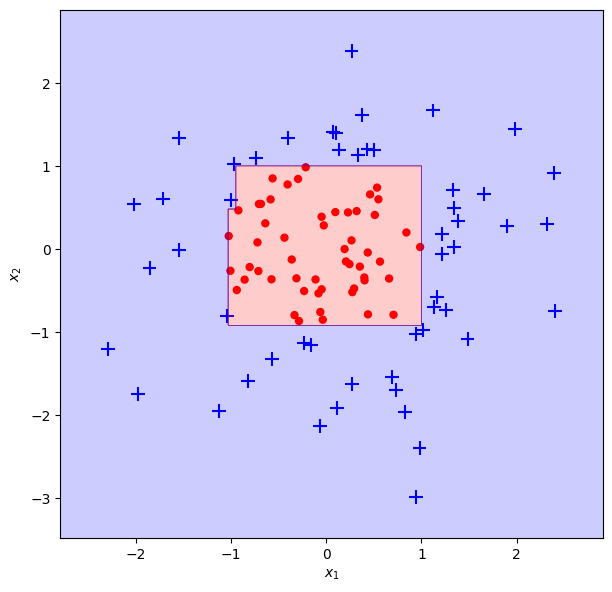

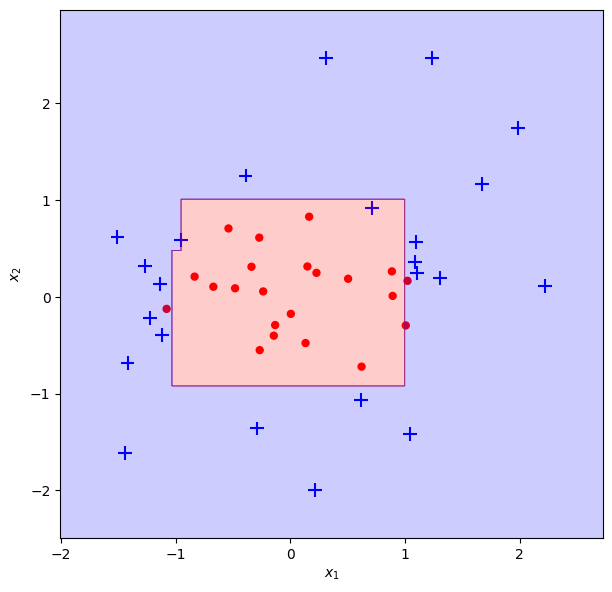

In [84]:
print("For number of data points ",n)
print("Minimum number of iterations for minimum training error is ",min_train)
print("Minimum number of iterations for minimum testing error is ",min_test)
print("The minimum number of iterations selected for n = ",n," is ",max(min_train,min_test))
print("Plotting the Adaboost classifier for above minimum iterations")
model = AdaBoost_classifier().fit_model(X_train,y_train,iterations=max(min_train,min_test),iteration_information=False)
plot_adaboost_in2D(X_train,y_train,model)
plot_adaboost_in2D(X_test,y_test,model)
train_err = (model.predict(X_train) != y_train).mean() * 100
print('Train error:',train_err)
test_err = (model.predict(X_test) != y_test).mean() * 100
print('Test error:',test_err)

# In this way we can see the different number of weak classifiers are required for different number of Data points.